In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread,imsave,imshow
from skimage.color import rgb2gray
from scipy.stats import norm, kurtosis, entropy, skew
from skimage.feature import graycoprops,graycomatrix
import cv2
from glob import glob
import os
import csv
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.metrics import accuracy_score as acc

#### Os seguintes valores são calculado com o histograma e são largamente utilizados para representar imagens:

- Média (INMB)
- Variância (INMB)
- Skewness (INMB)
- Kurtosis (Eu acho que tá ok!)
- Energia (Eu acho que tá ok!)
- Entropia (Eu acho que tá ok!)

In [2]:
def Ler_Cinza(imagem):
    # Função para realizar a leitura de uma imagem e retornar a imagem cinza.
    img = cv2.imread(imagem,0)
    return img

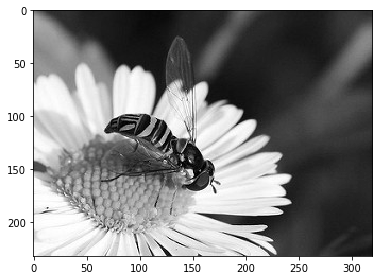

In [90]:
imagem = 'daisy.jpg'
cinza = cv2.imread(imagem,0)
imshow(cinza)

In [3]:
def Retorna_Histograma(Imagem):  
    # Função para retornar o histograma de uma imagem.
    Linhas, Colunas = Imagem.shape
    Array = []
    Valores = []
    for I in range(256):
        Array.append(0)
        Valores.append(I)
    for L in range(Linhas):
        for C in range(Colunas):
            # print(Imagem[L][C])
            Array[int(Imagem[L][C])] += 1   
    return [Array,Valores]

In [4]:
def Descritor_Histograma(imagem):
    Histograma = Retorna_Histograma(imagem)
    media = np.average(Histograma[0])
    variancia = np.var(Histograma[0])
    s = skew(Histograma[0])
    kur = kurtosis(Histograma[0])
    good = graycomatrix(imagem,[0],[0]) # Energia
    ener = graycoprops(good,'energy')
    ent = entropy(Histograma[0])
    return {
        'histograma': Histograma[0], 
        'media': media, 
        'var': variancia,
        'skewness': s, 
        'kurtosis': kur, 
        'energy': ener[0][0], 
        'entropy': ent}

In [93]:
print(Descritor_Histograma(cinza))

{'histograma': [97, 18, 26, 25, 27, 37, 27, 35, 28, 61, 89, 142, 227, 145, 148, 177, 222, 334, 421, 480, 568, 590, 571, 630, 663, 605, 605, 651, 657, 709, 859, 1018, 930, 928, 1013, 925, 957, 956, 940, 962, 1036, 871, 756, 606, 598, 648, 612, 592, 532, 521, 526, 481, 530, 563, 543, 542, 540, 503, 447, 419, 461, 372, 422, 380, 375, 348, 287, 277, 257, 255, 220, 230, 274, 274, 275, 318, 294, 259, 270, 216, 173, 168, 164, 147, 191, 158, 135, 162, 167, 150, 155, 151, 123, 133, 147, 146, 124, 123, 139, 117, 142, 121, 141, 151, 128, 114, 129, 138, 123, 123, 113, 127, 117, 115, 95, 107, 116, 103, 109, 109, 112, 120, 116, 111, 99, 123, 96, 102, 131, 135, 123, 123, 119, 141, 137, 119, 153, 160, 177, 205, 243, 217, 235, 247, 208, 188, 183, 171, 171, 151, 183, 188, 184, 198, 189, 188, 171, 157, 167, 137, 149, 146, 148, 114, 113, 132, 168, 129, 121, 154, 157, 139, 115, 147, 104, 130, 120, 133, 128, 130, 131, 133, 124, 119, 131, 132, 130, 135, 137, 139, 132, 158, 140, 133, 169, 142, 157, 171, 172, 

In [5]:
def contabilizaTamanhos(dataset):
    tamanhos = {'total': 0}
    for classe in dataset:
        tamanhos[classe] = len(dataset[classe])
        tamanhos['total'] += len(dataset[classe])
    dataset['tamanhos'] = tamanhos
    return dataset

In [6]:
def lerDataset(nameDataset):
    dataset = {}
    for classe in os.listdir(nameDataset):
        dataset[classe] = glob(f'flowers/{classe}/*', recursive=True)

    dataset = contabilizaTamanhos(dataset)
    
    return dataset

In [96]:
dataset = lerDataset('flowers')

In [97]:
dataset['tamanhos']

{'total': 4317,
 'daisy': 764,
 'sunflower': 733,
 'tulip': 984,
 'rose': 784,
 'dandelion': 1052}

In [98]:
dataset['daisy'][0:10] # Não preciso abrir todas as imagens, apenas ter os endereços para abrir quando precisar.

['flowers/daisy/14021430525_e06baf93a9.jpg',
 'flowers/daisy/16020253176_60f2a6a5ca_n.jpg',
 'flowers/daisy/7133935763_82b17c8e1b_n.jpg',
 'flowers/daisy/9515186037_3be48fe68f.jpg',
 'flowers/daisy/15327813273_06cdf42210.jpg',
 'flowers/daisy/3285641623_da0e47f49a.jpg',
 'flowers/daisy/9299302012_958c70564c_n.jpg',
 'flowers/daisy/8071646795_2fdc89ab7a_n.jpg',
 'flowers/daisy/5885826924_38fdc6bcaa_n.jpg',
 'flowers/daisy/5512287917_9f5d3f0f98_n.jpg']

In [99]:
imgTesteBlack = Ler_Cinza(dataset['daisy'][0])

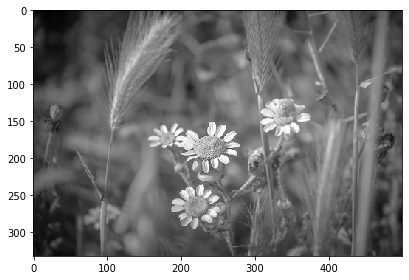

In [100]:
imshow(imgTesteBlack)

In [101]:
imgTesteBlack

array([[ 4,  4,  5, ..., 34, 34, 34],
       [ 5,  5,  6, ..., 36, 36, 36],
       [ 7,  7,  8, ..., 40, 40, 40],
       ...,
       [ 7, 11, 19, ..., 29, 25, 22],
       [ 6,  9, 16, ..., 28, 24, 21],
       [ 7,  7, 15, ..., 26, 23, 21]], dtype=uint8)

In [102]:
Descritor_Histograma(imgTesteBlack)

{'histograma': [0,
  0,
  0,
  16,
  112,
  78,
  101,
  75,
  127,
  220,
  98,
  80,
  97,
  109,
  136,
  174,
  203,
  223,
  300,
  274,
  259,
  279,
  367,
  393,
  414,
  404,
  428,
  350,
  329,
  388,
  322,
  329,
  297,
  313,
  312,
  301,
  361,
  350,
  394,
  343,
  394,
  410,
  456,
  396,
  417,
  471,
  462,
  547,
  615,
  553,
  619,
  684,
  685,
  707,
  717,
  672,
  698,
  748,
  807,
  762,
  819,
  954,
  992,
  1034,
  1082,
  1048,
  1138,
  1109,
  1136,
  1181,
  1209,
  1186,
  1291,
  1451,
  1452,
  1514,
  1464,
  1590,
  1548,
  1479,
  1484,
  1388,
  1491,
  1567,
  1558,
  1556,
  1552,
  1542,
  1548,
  1617,
  1782,
  1751,
  1831,
  1817,
  1829,
  1828,
  1890,
  1894,
  1918,
  2031,
  2057,
  2116,
  2174,
  2145,
  2216,
  2119,
  2111,
  2115,
  2028,
  1961,
  1888,
  1834,
  1909,
  1787,
  1884,
  1760,
  1726,
  1686,
  1625,
  1591,
  1567,
  1660,
  1584,
  1514,
  1469,
  1501,
  1503,
  1494,
  1396,
  1301,
  1340,
  1272,
  120

In [7]:
def criaLinhaCsv(d, arquivo='matriz.csv'):
    # ordem: nomeArq,largura,altura,media,variancia,skewness,kurtosis,energy,entropy,className,classId
    linha = [d['img'], d['largura'], d['altura'], d['media'], d['var'], d['skewness'], d['kurtosis'], d['energy'], d['entropy'], d['classe'], d['classeId']]
    
    with open(arquivo, 'a') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(linha)

In [8]:
def criaMatriz(dataset, arquivo):
    matriz = []
    count = 0
    for index, classe in enumerate(dataset):
        print(f'Inserindo dados da classe {index} referente as {classe}')
        for img in dataset[classe]:
            imagem = Ler_Cinza(img)
            descritor = Descritor_Histograma(imagem)
            descritor['classe'] = classe
            descritor['img'] = img
            descritor['classeId'] = index
            descritor['largura'], descritor['altura'] = imagem.shape

            criaLinhaCsv(descritor, arquivo)

In [ ]:
# Função que cria a matriz. Não vou executar pelo o tempo.
# criaMatriz(dataset, 'matriz.csv')

In [106]:
matriz = pd.read_csv('matriz.csv')

In [107]:
matriz

,nomeArq,largura,altura,media,variancia,skewness,kurtosis,energy,entropy,className,classId
0,flowers/daisy/14021430525_e06baf93a9.jpg,333,500,650.390625,4.305069e+05,0.883166,-0.666345,0.088779,5.052118,daisy,0
1,flowers/daisy/16020253176_60f2a6a5ca_n.jpg,213,320,266.250000,9.106384e+04,1.223845,0.354793,0.094468,4.952714,daisy,0
2,flowers/daisy/7133935763_82b17c8e1b_n.jpg,240,320,300.000000,1.115515e+07,15.760917,247.850545,0.698621,1.989818,daisy,0
3,flowers/daisy/9515186037_3be48fe68f.jpg,332,500,648.437500,7.628419e+05,1.170088,-0.176194,0.104848,4.713249,daisy,0
4,flowers/daisy/15327813273_06cdf42210.jpg,333,500,650.390625,3.119289e+05,1.320694,1.011749,0.082382,5.201902,daisy,0
...,...,...,...,...,...,...,...,...,...,...,...
4312,flowers/dandelion/14053173516_a00150a919_m.jpg,217,240,203.437500,1.586426e+04,-0.134806,-1.060093,0.073509,5.295406,dandelion,4
4313,flowers/dandelion/16242239484_51286673af.jpg,333,500,650.390625,5.849189e+05,1.137821,1.092908,0.096476,4.814290,dandelion,4
4314,flowers/dandelion/2076141453_c63801962a_m.jpg,240,180,168.750000,2.680252e+04,1.570786,2.846115,0.087080,5.116246,dandelion,4
4315,flowers/dandelion/3021333497_b927cd8596.jpg,334,500,652.343750,1.618753e+07,15.788924,248.523061,0.390507,3.911336,dandelion,4


---
## Scatter Plot
Os gráficos de dispersão ou Scatter plot são representações gráficas do relacionamento entre duas variáveis numéricas. O Scatter plot utiliza pontos para representar essa relação, cada ponto representa o valor de uma variável no eixo horizontal e o valor de outra variável no eixo vertical.

Fonte: https://www.flai.com.br/juscudilio/scatter-plot-um-guia-completo-para-graficos-de-dispersao/

In [2]:
matriz = pd.read_csv('matriz.csv')

In [17]:
matriz.keys()

Index(['nomeArq', 'largura', 'altura', 'media', 'variancia', 'skewness',
       'kurtosis', 'energy', 'entropy', 'className', 'classId'],
      dtype='object')

In [22]:
def plotaScatter(matriz, x, y, tamanho=400, titulo="Scatter Plot", xLabel="X", yLabel="Y"):
    fig  = px.scatter(matriz, x=x, y =y, log_x = True, width=tamanho+300, height=tamanho)
    fig.update_traces(marker = dict(size = 4, line=dict(width = 2)), selector = dict(mode = 'markers'))
    fig.update_layout(title = titulo)
    fig.update_xaxes(title = xLabel)
    fig.update_yaxes(title = yLabel)
    fig.show()

In [24]:
atributos = [ ['media', 'variancia'], ['skewness', 'kurtosis'], [ 'energy', 'entropy'] ]
for i in atributos:
    plotaScatter(matriz, i[0], i[1], 400, f'Scatter Plot de {i[0]} com {i[1]}', i[0], i[1])

---
## Classificação

In [10]:
matriz.head()

,nomeArq,largura,altura,media,variancia,skewness,kurtosis,energy,entropy,className,classId
0,flowers/daisy/14021430525_e06baf93a9.jpg,333,500,650.390625,4.305069e+05,0.883166,-0.666345,0.088779,5.052118,daisy,0
1,flowers/daisy/16020253176_60f2a6a5ca_n.jpg,213,320,266.250000,9.106384e+04,1.223845,0.354793,0.094468,4.952714,daisy,0
2,flowers/daisy/7133935763_82b17c8e1b_n.jpg,240,320,300.000000,1.115515e+07,15.760917,247.850545,0.698621,1.989818,daisy,0
3,flowers/daisy/9515186037_3be48fe68f.jpg,332,500,648.437500,7.628419e+05,1.170088,-0.176194,0.104848,4.713249,daisy,0
4,flowers/daisy/15327813273_06cdf42210.jpg,333,500,650.390625,3.119289e+05,1.320694,1.011749,0.082382,5.201902,daisy,0


In [35]:
# cria um array normal com os dados: media, variancia, skewness, kurtosis, energy, entropy
def pegaMatrizAux(matriz):
    m = matriz[['media', 'variancia', 'skewness', 'kurtosis', 'energy', 'entropy']].values
    y = matriz['classId'].values
    return m, y

In [36]:
matrizAux, y = pegaMatrizAux(matriz);

In [37]:
for i in matrizAux:
    print(i)

[ 6.50390625e+02  4.30506949e+05  8.83166484e-01 -6.66344960e-01
  8.87792153e-02  5.05211835e+00]
[2.66250000e+02 9.10638438e+04 1.22384482e+00 3.54793048e-01
 9.44680115e-02 4.95271416e+00]
[3.00000000e+02 1.11551532e+07 1.57609170e+01 2.47850545e+02
 6.98620702e-01 1.98981775e+00]
[ 6.48437500e+02  7.62841855e+05  1.17008835e+00 -1.76194434e-01
  1.04848379e-01  4.71324855e+00]
[6.50390625e+02 3.11928910e+05 1.32069444e+00 1.01174862e+00
 8.23817027e-02 5.20190181e+00]
[7.32421875e+02 6.73655713e+05 3.47352740e+00 1.73220584e+01
 9.38704490e-02 5.11364005e+00]
[2.81250000e+02 3.59967394e+06 1.52926336e+01 2.37030094e+02
 4.26225206e-01 3.63168069e+00]
[2.66250000e+02 1.73241109e+05 2.44598785e+00 6.06250140e+00
 1.15984814e-01 4.68461068e+00]
[ 2.87500000e+02  2.88827422e+04  8.53036641e-01 -5.23321134e-01
  7.26031605e-02  5.38215833e+00]
[3.02500000e+02 2.16669226e+06 6.19313462e+00 3.90579298e+01
 3.10481477e-01 2.84105057e+00]
[3.12500000e+02 9.60481328e+04 1.85000733e+00 3.6555

In [65]:
def classification(X,y):

    """
    X é uma matriz onde cada linha corresponde aos atributos calculados com o descritor
    y são os rótulos da classe de cada imagem. Exemplo [0,1,0,0,1,2,2,0,0,0,...,1]
    """
    
    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7)
    # criar instancia do classificador
    clf = mlp()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    
    return acuracia

In [70]:
acuracia = classification(matrizAux, y)

In [71]:
f"Acuracia: {(round(acuracia, 4) * 100)} %"

'Acuracia: 19.52 %'